# Evaluation notebook with Grad-CAM Visualization

Grad-CAM uses the gradients of any target class flowing into the final convolutional layer to produce a coarse localization map highlighting the important regions in the image for predicting the class. The colors range from blue (low importance) to red (high importance), indicating how much each modality contributed to the model's output. In this visualization, the areas in red contribute most strongly to the model's classification.

## Library Imports
This cell imports all the necessary libraries and modules required for the evaluation of the machine learning model.

In [1]:
import os
os.chdir('../')
%pwd

import cv2
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import tensorflow as tf

from src.constants import *
from src.utils.utils import *
from src.utils.grad_cam_eval import GradCAMVisualizer

2023-11-19 22:46:37.939517: I tensorflow/core/util/port.cc:111] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-11-19 22:46:37.961807: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-11-19 22:46:37.961830: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-11-19 22:46:37.961845: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-11-19 22:46:37.966370: I tensorflow/core/platform/cpu_feature_g

## Data Loading
This cell loads the test dataset and prepares it for evaluation by the model.

In [2]:
# Load test data from pickle file
test_df = load_dataframe_from_pickle(os.path.join(SAVED_DATASET_DIR, "test_data_LOSegO_4_1_1Hz.pkl"))
test_data, test_labels = dataframe_to_array(test_df)

## Model Evaluation
This cell loads the trained model and evaluates it on the test dataset, outputting the evaluation metrics.

5/5 [==============================] - 0s 6ms/step
Accuracy: 95.71428571428572


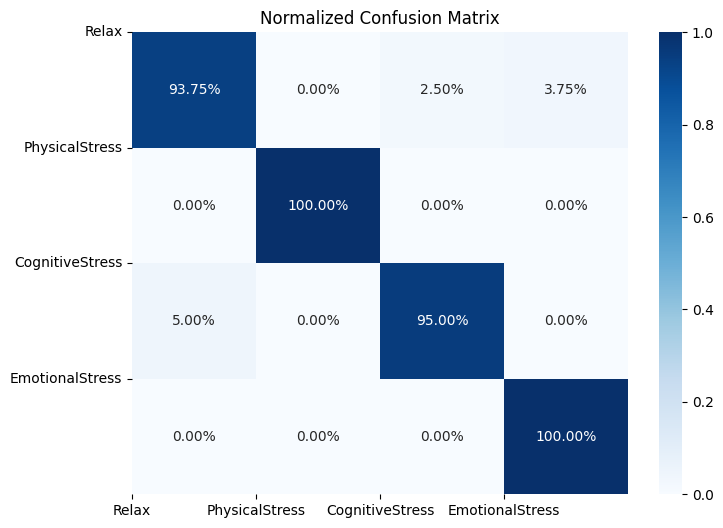

In [8]:
# Load the model
MODEL_PATH = os.path.join(SAVED_MODEL_DIR, 'model.h5')
model = tf.keras.models.load_model(MODEL_PATH)

# Evaluate the test data
evaluate_test_data(test_data, test_labels, model, train_data_mean=TRAIN_DATA_MEAN, train_data_std=TRAIN_DATA_STD)

## GradCAM Visualization
This cell sets up the GradCAM visualizer for the model, which can be used to generate visual explanations for the model's predictions.

In [4]:
# Instantiate GradCAMVisualizer with the model and activation layer for Grad-CAM analysis
visualizer = GradCAMVisualizer(model=model, model_layer=ACTIVATION_LAYER_NAME, modals=MODALS, labels=LABELS)

### Visualize Grad-CAM for each label and for each modality for one subject

2023-11-19 22:47:40.936794: W tensorflow/compiler/mlir/tools/kernel_gen/transforms/gpu_kernel_to_blob_pass.cc:191] Failed to compile generated PTX with ptxas. Falling back to compilation by driver.


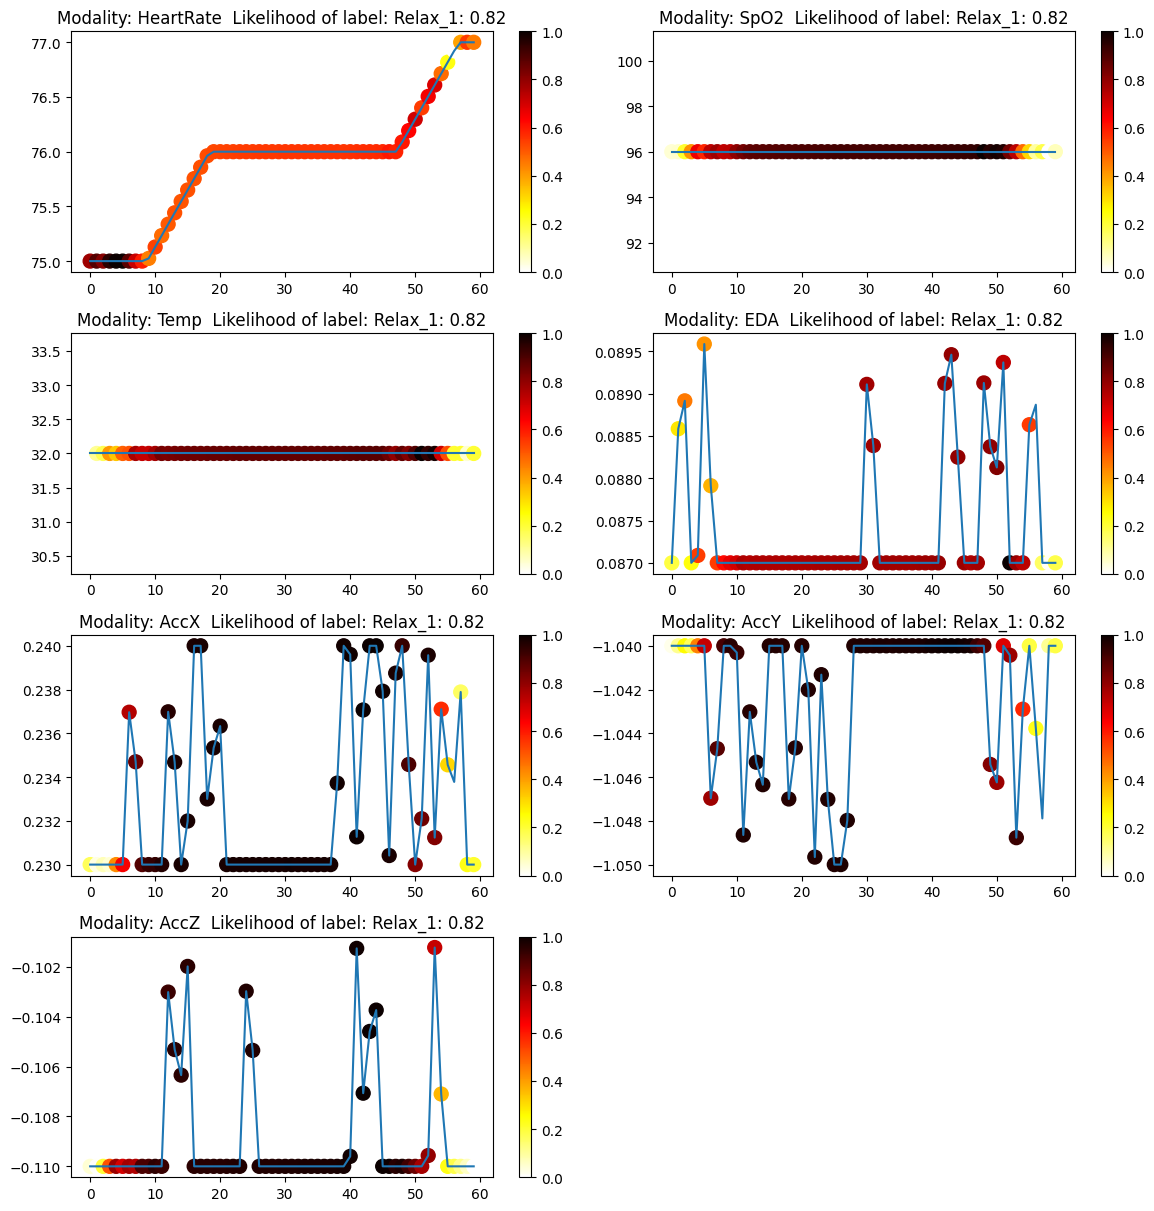

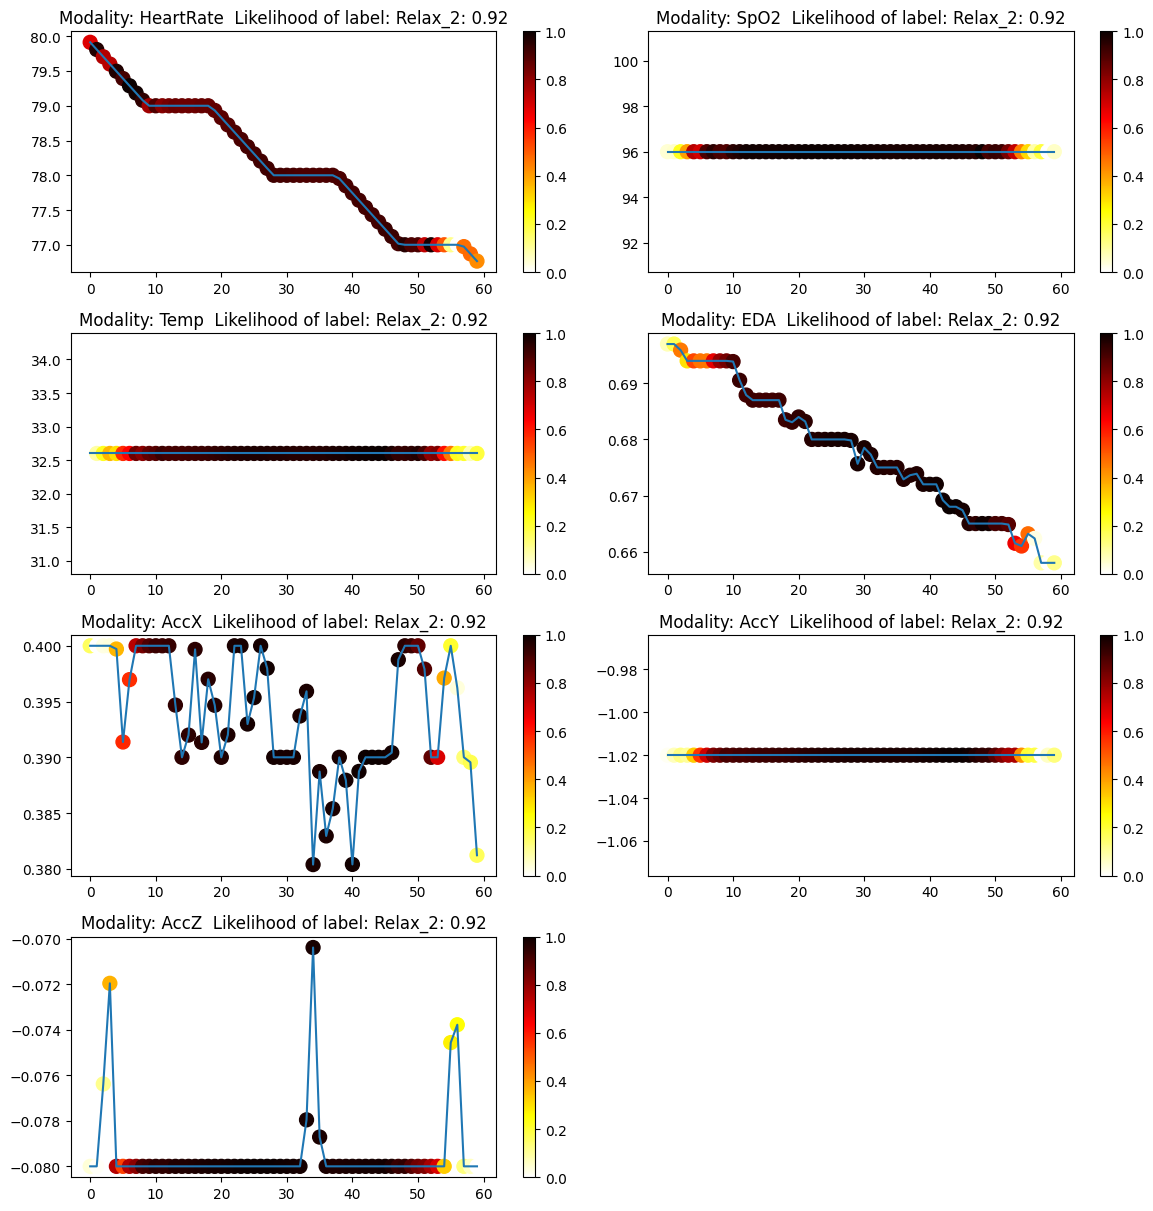

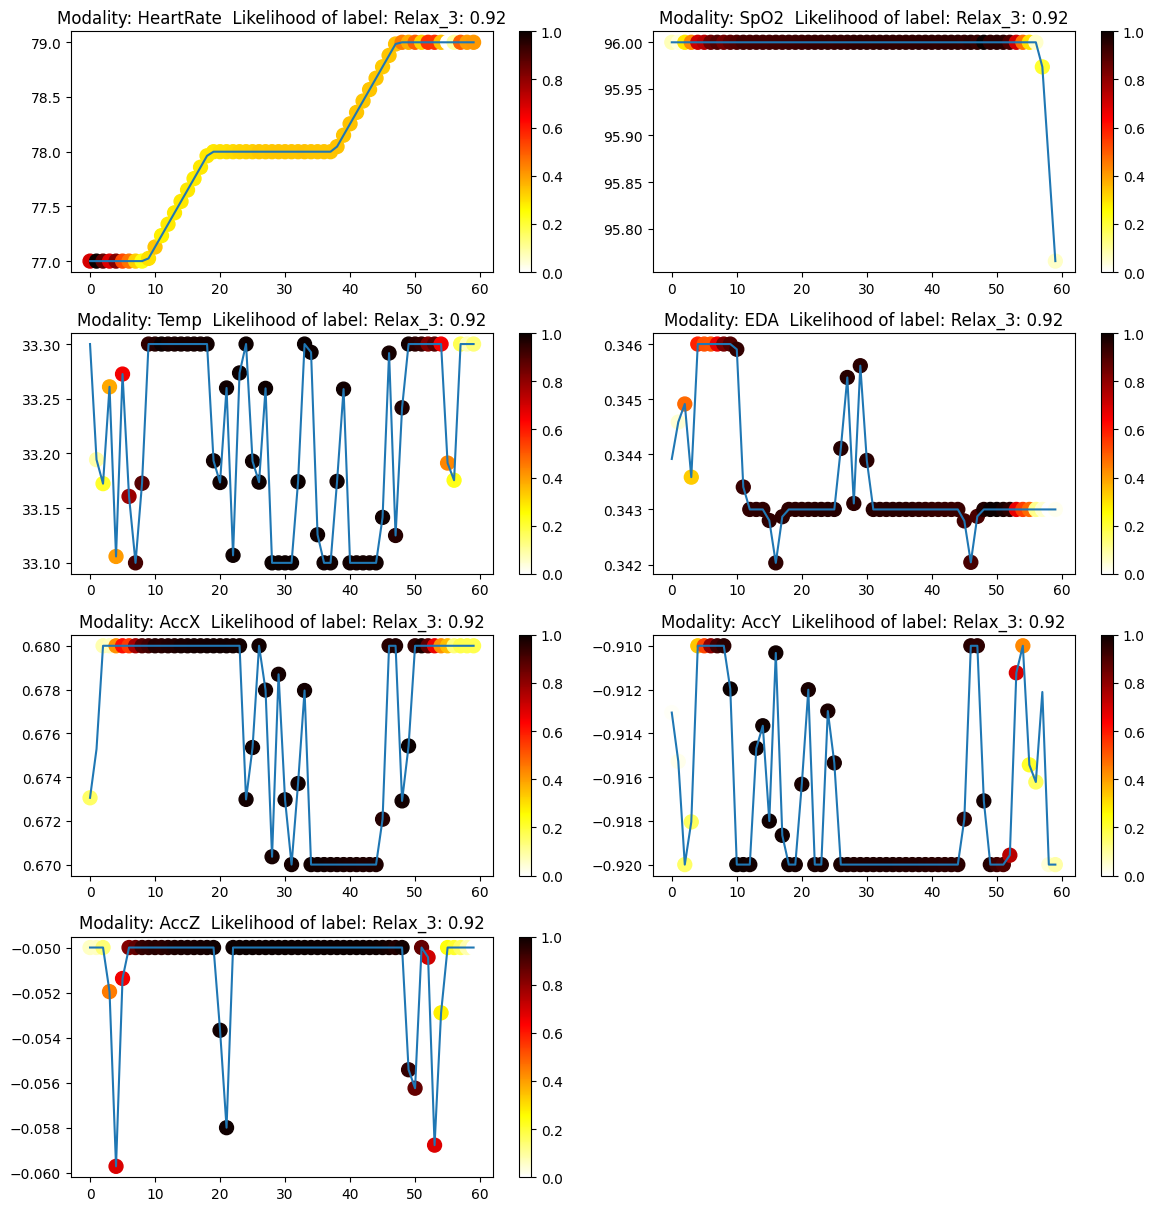

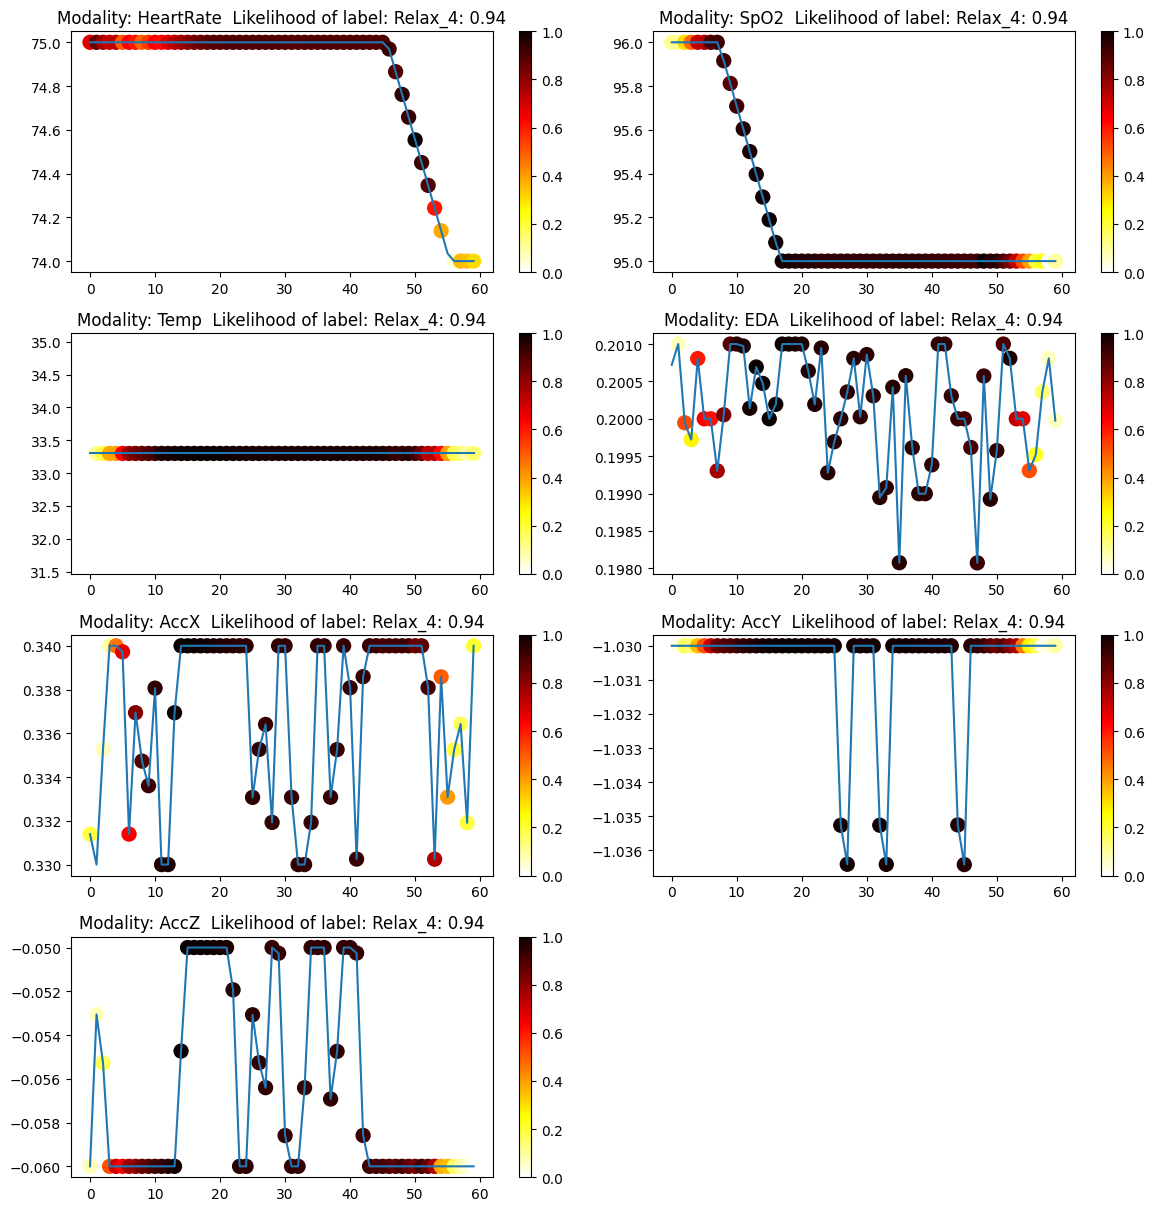

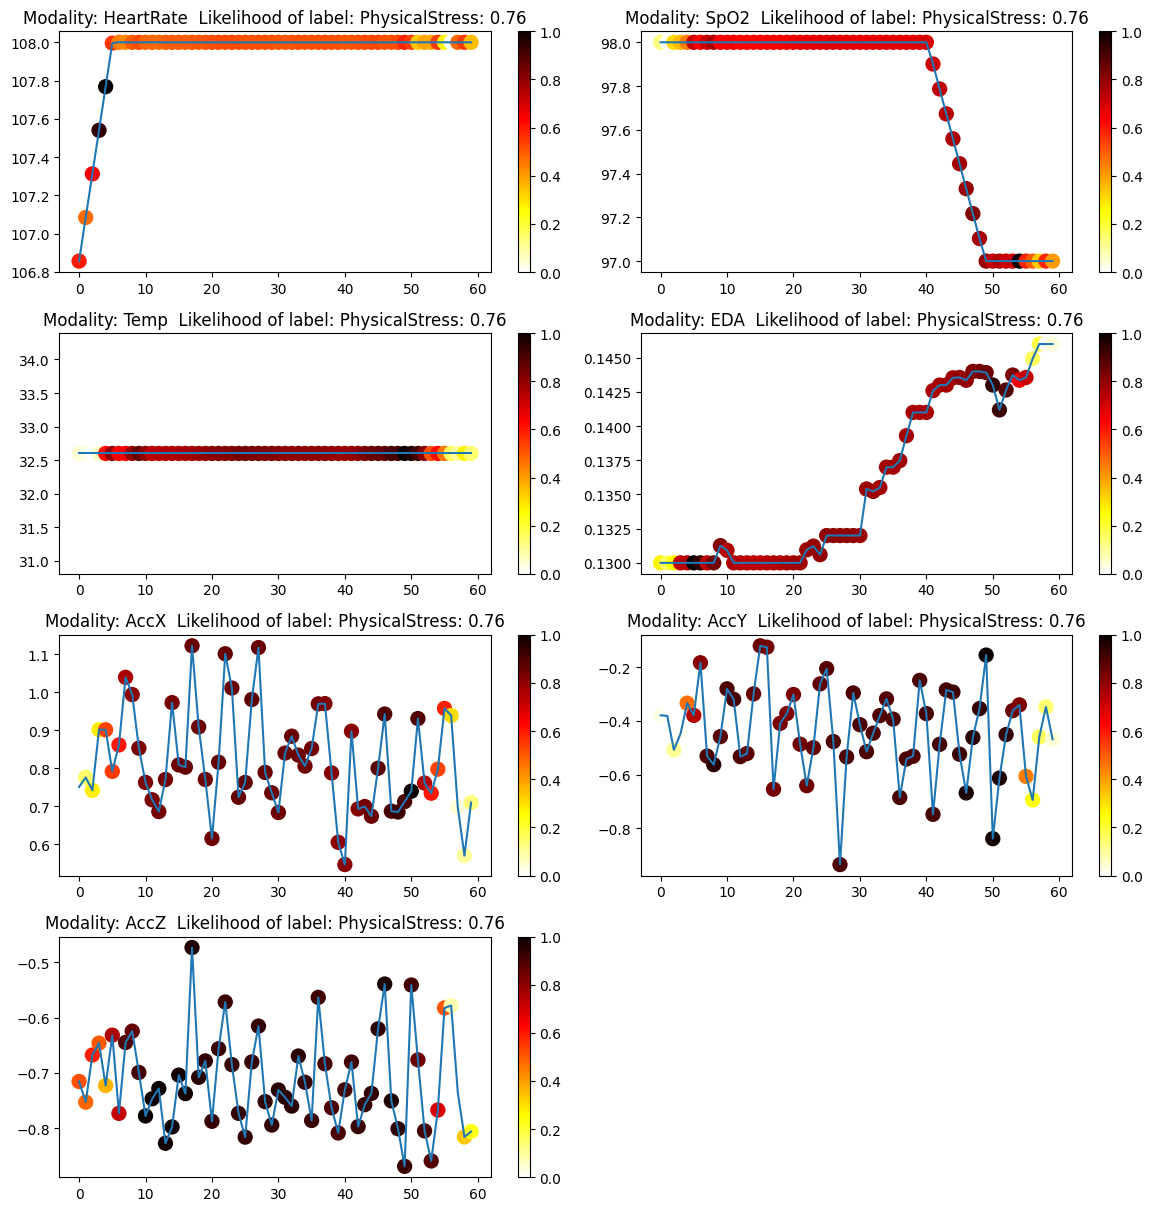

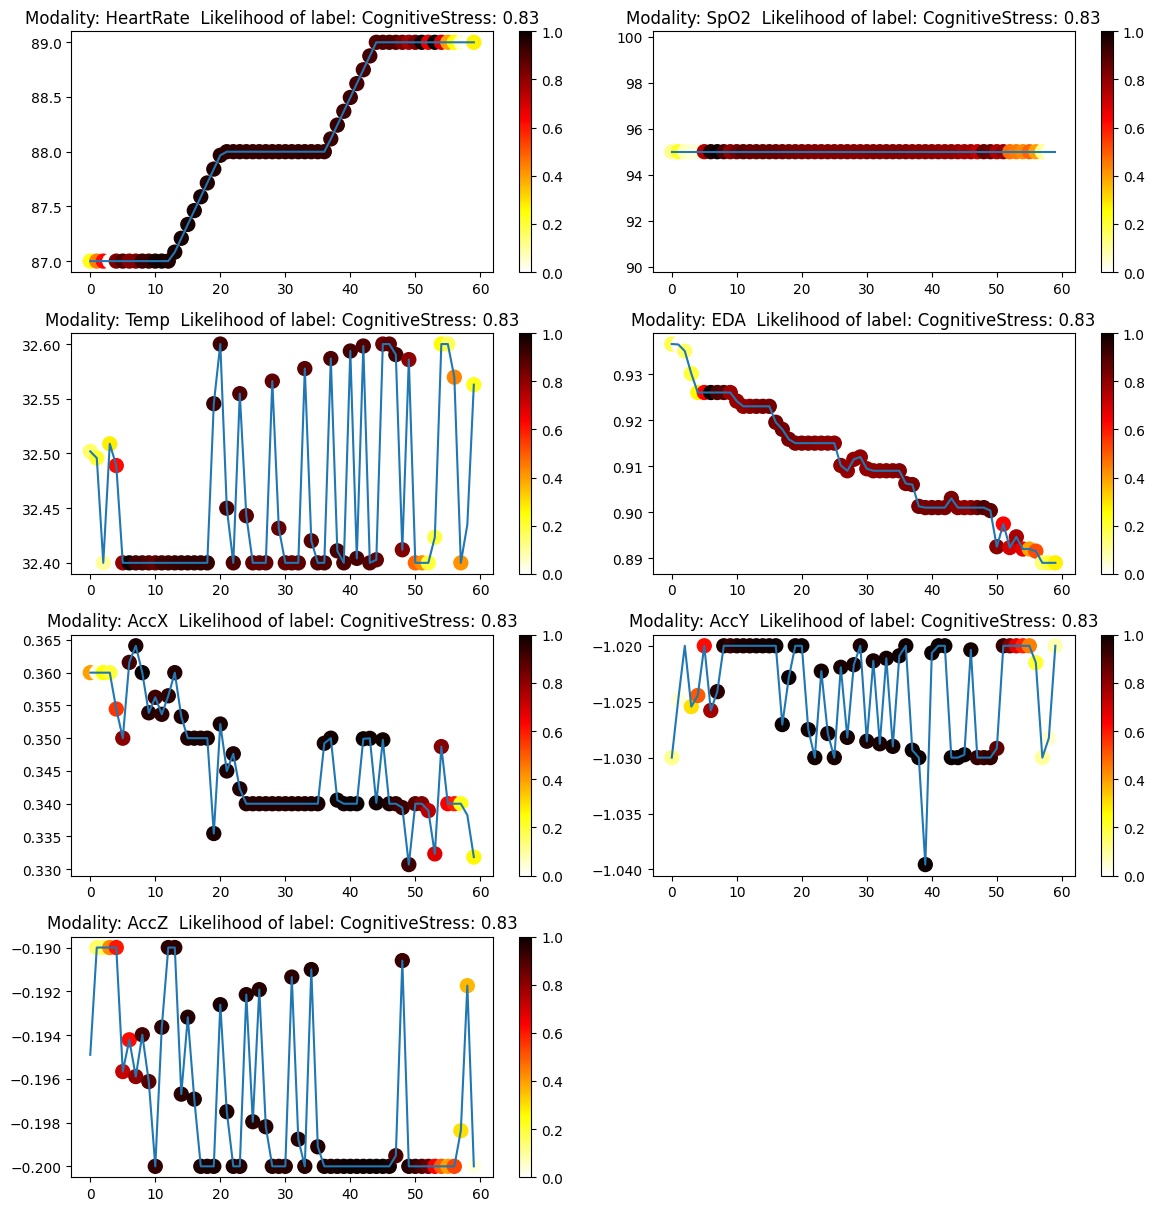

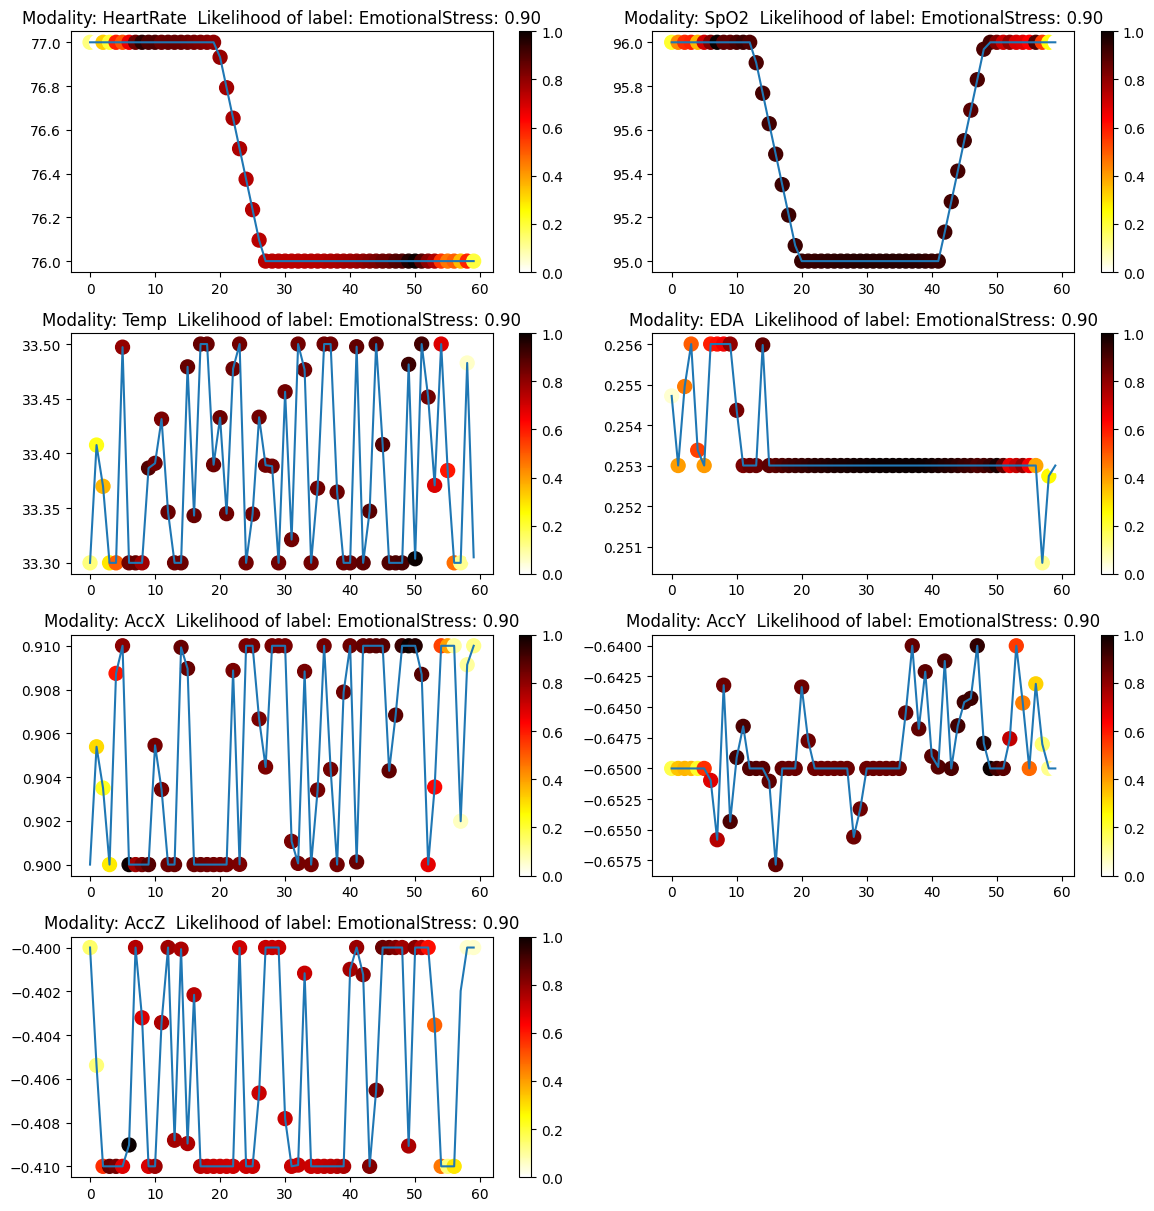

In [5]:
# Iterate over the range from 0 to 7 and call the function to visualize Grad-CAM for each label and for each modality for one subject
for label in range(len(LABELS)):
    visualizer.vis_grad_cam_one_modal(test_df[label:label+1], label_index=label)

## Visualize Grad-CAM for each label as a heatmap

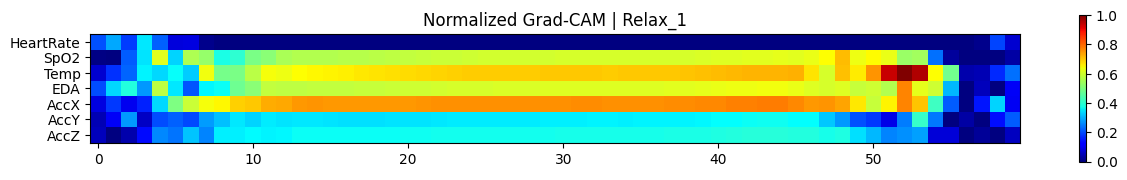

In [9]:
# Visualize Grad-CAM for all modalities 
for label in range(1):
    normalized_hm = visualizer.vis_grad_cam_all_modal(test_df[label:label+1], color=False, plot=True)

## Visualize Average Grad-CAM for each label for the entire test dataset

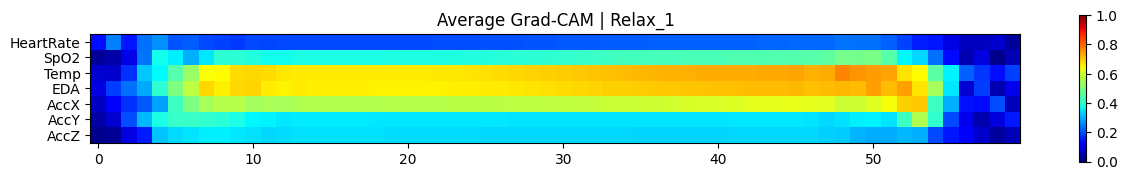

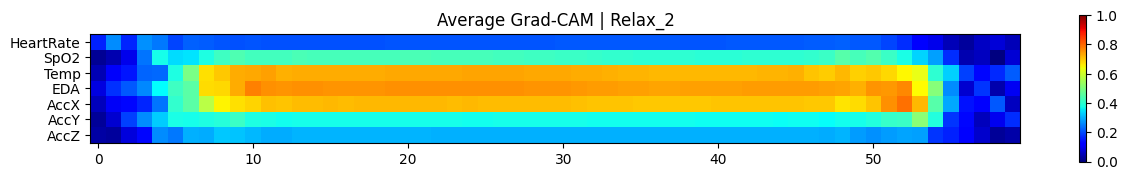

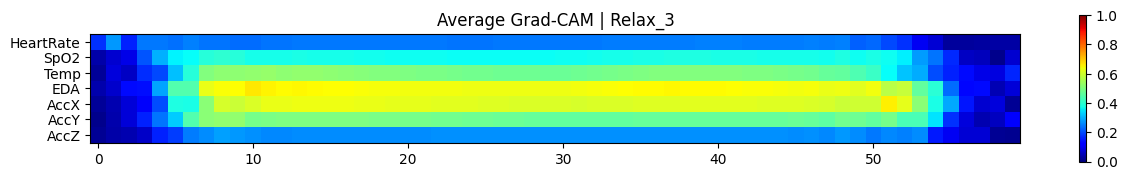

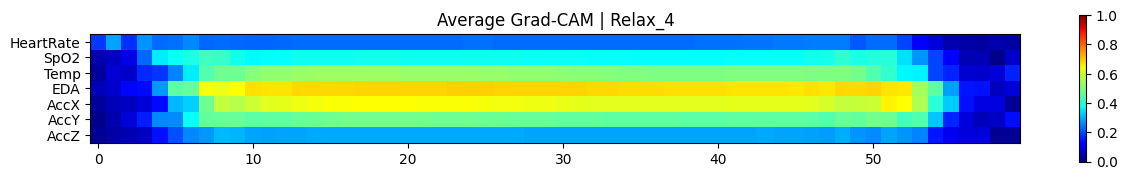

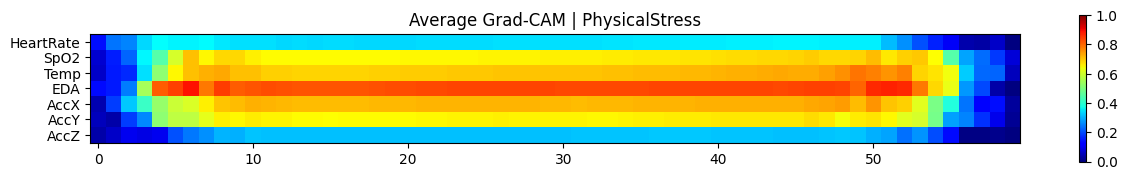

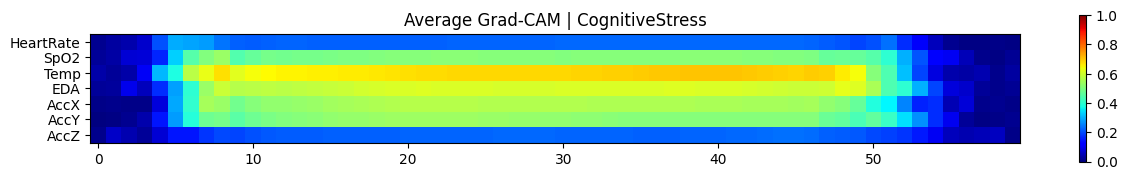

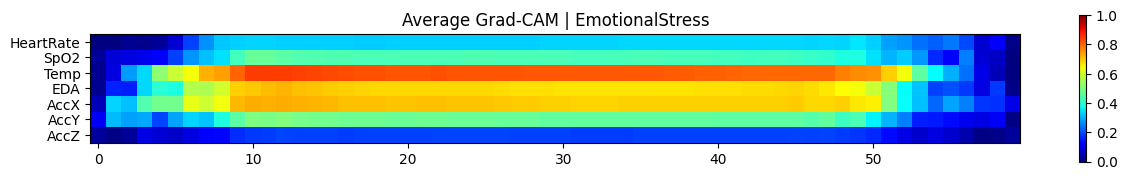

In [7]:
# Average Grad-CAM for each label 
visualizer.average_grad_cam(test_df)